# Validating a trained network

In this notebook I will validate the model trained in
[Inceptionv3_21](inception_v3_experiments/Inceptionv3_21.ipynb)

In [119]:
import itertools
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix,\
                            precision_recall_fscore_support, roc_auc_score, brier_score_loss

from custom.tools import plot_metrics, pickle_variable_to_path

## Image, directory, and batch setup

In [37]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 299, 299

WORKING_DIR = os.getcwd()
BASE = os.path.join(WORKING_DIR, 'data', 'cars_dataset', 'keras')
DATA_DIR = os.path.join(WORKING_DIR, 'data', 'InceptionV3')
PREDICT_DIR = os.path.join(WORKING_DIR, 'data', 'predict_me')
LOOKUP_PATH = os.path.join(DATA_DIR, 'I_15_lookup_dict.pkl')
TEST_DIR = os.path.join(BASE, 'test')
SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'notebooks', '5_model_validation')

NB_CLASSES = 196

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

## Model definition

In [6]:
JSON_PATH = os.path.join(DATA_DIR, 'InceptionV3_21_FT3_30_40.json')
with open (JSON_PATH, 'r') as json_file:
    loaded_model_json = json_file.read()

json_model = model_from_json(loaded_model_json)

In [7]:
WEIGHT_PATH = os.path.join(DATA_DIR, 'InceptionV3_21_FT3_30_40.h5')
json_model.load_weights(WEIGHT_PATH)

### Predict!

In [8]:
test_file_list = [f for f in os.listdir(PREDICT_DIR) if\
                   os.path.isfile(os.path.join(PREDICT_DIR, f))]

with open(LOOKUP_PATH, 'rb') as f:
    lookup_dict = pickle.load(f)

for test_file in test_file_list:
    file_path = os.path.join(PREDICT_DIR, test_file)
    input_image = load_img(file_path, 
                           target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_image = img_to_array(input_image)
    # the images are scaled during training so they need to be scaled for predictions too
    input_image = input_image/255.
    input_image = np.expand_dims(input_image, axis=0)
    prediction = json_model.predict(input_image)
    top_3 = prediction[0].argsort()[-3:][::-1]
    print('\nPredictions for {}:'.format(test_file))
    for idx in top_3:
        print(lookup_dict.get(idx))


Predictions for Dodge-Ram_Pickup_3500_Crew_Cab-2010.jpg:
Dodge-Ram_Pickup_3500_Crew_Cab-2010
Dodge-Ram_Pickup_3500_Quad_Cab-2009
Dodge-Durango_SUV-2007

Predictions for Audi-100_Sedan-1994.jpg:
Audi-100_Sedan-1994
Audi-V8_Sedan-1994
Volvo-240_Sedan-1993

Predictions for AM-General_Hummer_SUV-2000.jpg:
AM-General_Hummer_SUV-2000
HUMMER-H2_SUT_Crew_Cab-2009
HUMMER-H3T_Crew_Cab-2010

Predictions for Aston_Martin-Martin_V8_Vantage_Convertible-2012.jpg:
Aston_Martin-Martin_V8_Vantage_Convertible-2012
Aston_Martin-Martin_V8_Vantage_Coupe-2012
BMW-Z4_Convertible-2012


### Plot training and validation curves

In [11]:
# load all four training curves for the same experiment 
# (no fine tuning through 3 rounds of fine tuning)

file_name_list = ['InceptionV3_21_0_10.pkl',
                  'InceptionV3_21_FT1_10_20.pkl',
                  'InceptionV3_21_FT2_20_30.pkl',
                  'InceptionV3_21_FT3_30_40.pkl',]

summary_list = []
for file_name in file_name_list:
    file_path = os.path.join(DATA_DIR, file_name)
    with open(file_path, 'rb') as file:
        summary = pickle.load(file)
        summary_list.append(summary)

In [20]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'top_5_acc',
            'loss']

compiled_summary = {}
for key in key_list:
    for summary in summary_list:
        val_key = 'val_' + key
        #initialize the first time
        if not compiled_summary.get(key):
            compiled_summary[key] = []
            compiled_summary[val_key] = []
        compiled_summary[key].extend(summary[key])
        compiled_summary[val_key].extend(summary[val_key])

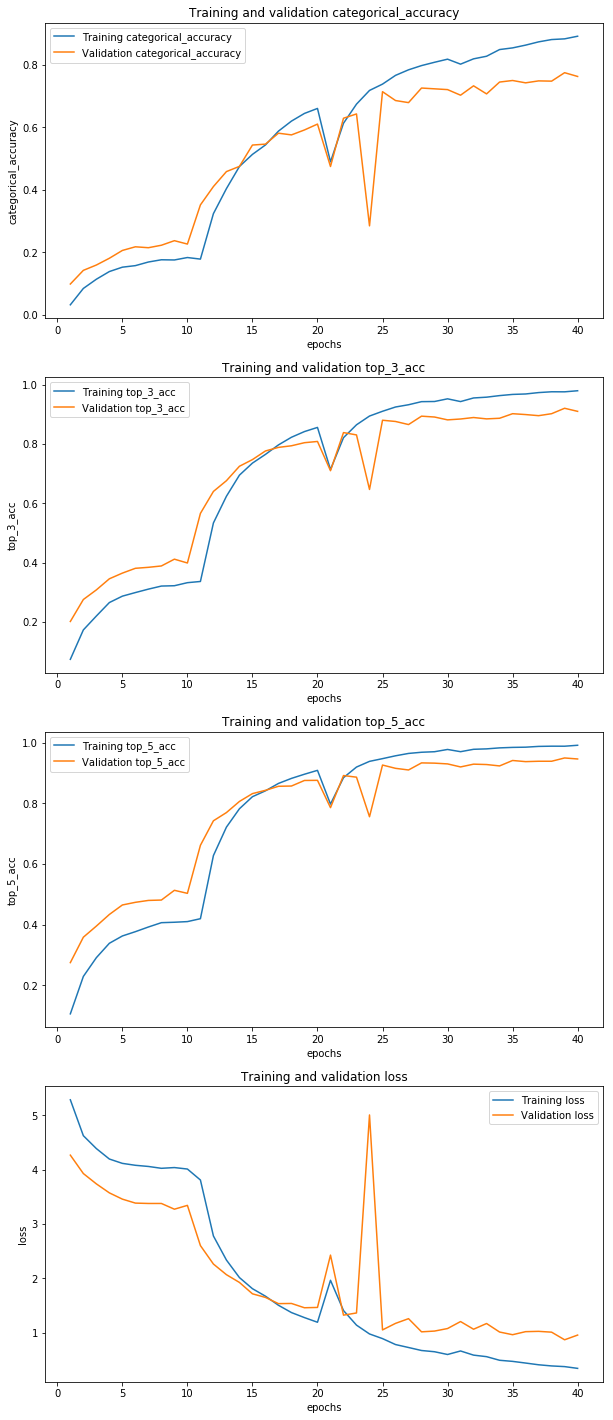

In [22]:
show = plot_metrics(compiled_summary, key_list)

In [23]:
final_scores = {}
for key in key_list:
    val_key = 'val_' + key
    final_scores[key] = compiled_summary[key][-1]
    final_scores[val_key] = compiled_summary[val_key][-1]
for key, item in final_scores.items():
    print(key, item)

categorical_accuracy 0.891741170222
val_categorical_accuracy 0.762916666667
top_3_acc 0.979994688855
val_top_3_acc 0.910416666667
top_5_acc 0.991413649641
val_top_5_acc 0.94625
loss 0.342312268048
val_loss 0.955460006793


### Generate the test set predictions

In [27]:
test_datagen = ImageDataGenerator(rescale=1/255)

In [28]:
BATCH_SIZE = 2428
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=13)

Found 2428 images belonging to 196 classes.


In [29]:
test_batch = next(test_generator)

In [34]:
print('input shape: {}, input label shape: {}'.format(test_batch[0].shape, test_batch[1].shape))

input shape: (2428, 299, 299, 3), input label shape: (2428, 196)


In [35]:
test_y_true = test_batch[1]

In [36]:
test_y_pred = json_model.predict(test_batch[0])

In [38]:
pickle_variable_to_path(test_y_true, 'test_y_true', SAVE_DIR)
pickle_variable_to_path(test_y_pred, 'test_y_pred', SAVE_DIR)

# Validate the test set predictions

### Accuracy scores

In [89]:
overlap_array = K.eval(categorical_accuracy(test_y_true, test_y_pred))
average_of_array = np.sum(overlap_array)/len(overlap_array)
final_scores['test_categorical_accuracy'] = average_of_array
final_scores['test_top_3_acc'] = K.eval(top_k_categorical_accuracy(test_y_true, test_y_pred, k=3))
final_scores['test_top_5_acc'] = K.eval(top_k_categorical_accuracy(test_y_true, test_y_pred, k=5))

for key, item in final_scores.items():
    print(key, item)

categorical_accuracy 0.891741170222
val_categorical_accuracy 0.762916666667
top_3_acc 0.979994688855
val_top_3_acc 0.910416666667
top_5_acc 0.991413649641
val_top_5_acc 0.94625
loss 0.342312268048
val_loss 0.955460006793
test_categorical_accuracy 0.771004942339
test_top_3_acc 0.91804
test_top_5_acc 0.947694


### F1 scores

In [90]:
target_names = [''] * len(lookup_dict)
for key in lookup_dict.keys():
    target_names[key] = lookup_dict[key]

sk_true = np.argmax(test_y_true, axis=1)
sk_pred = np.argmax(test_y_pred, axis=1)

In [91]:
report = classification_report(sk_true, sk_pred, target_names=target_names)
print(report)

                                                        precision    recall  f1-score   support

                            AM-General_Hummer_SUV-2000       0.91      0.83      0.87        12
                             Acura-Integra_Type_R-2001       0.86      0.60      0.71        10
                                   Acura-RL_Sedan-2012       0.67      0.73      0.70        11
                                   Acura-TL_Sedan-2012       0.62      0.89      0.73         9
                                  Acura-TL_Type_S-2008       0.82      0.82      0.82        11
                                  Acura-TSX_Sedan-2012       1.00      0.75      0.86         8
                              Acura-ZDX_Hatchback-2012       0.80      0.89      0.84         9
       Aston_Martin-Martin_V8_Vantage_Convertible-2012       1.00      0.32      0.48        22
             Aston_Martin-Martin_V8_Vantage_Coupe-2012       0.50      0.53      0.52        15
           Aston_Martin-Martin_Virage_C

In [110]:
prfs_results = precision_recall_fscore_support(sk_true, sk_pred, average=None)
zipped_prfs = list(zip(target_names, prfs_results[0], prfs_results[1], prfs_results[2], prfs_results[3],))
sorted_prfs = sorted(zipped_prfs, key=lambda tup: tup[3])

In [107]:
reverse_lookup_dict = {val: key for key, val in lookup_dict.items()}
cnf_matrix = confusion_matrix(sk_true, sk_pred)

In [118]:
for fail in sorted_prfs[0:5]:
    print('\nSummary for:', fail[0])
    fail_cnf = cnf_matrix[reverse_lookup_dict[fail[0]],:]
    pred_idx = np.nonzero(fail_cnf)
    pred_labels = list(zip(np.array(target_names)[pred_idx], fail_cnf[pred_idx]))
    for tup in pred_labels:
        print(tup)


Summary for: Audi-A5_Coupe-2012
('Audi-A5_Coupe-2012', 2)
('Audi-S4_Sedan-2007', 1)
('Audi-S5_Coupe-2012', 5)
('Audi-TTS_Coupe-2012', 3)

Summary for: Audi-S4_Sedan-2012
('Audi-A5_Coupe-2012', 1)
('Audi-S4_Sedan-2012', 2)
('Audi-S5_Coupe-2012', 5)
('Audi-TTS_Coupe-2012', 1)
('BMW-1_Series_Coupe-2012', 1)

Summary for: Audi-S5_Coupe-2012
('Audi-A5_Coupe-2012', 2)
('Audi-S5_Convertible-2012', 1)
('Audi-S5_Coupe-2012', 8)
('Audi-TTS_Coupe-2012', 3)

Summary for: Rolls_Royce-Phantom_Drophead_Coupe_Convertible-2012
('Ford-Mustang_Convertible-2007', 1)
('Mercedes_Benz-300_Class_Convertible-1993', 1)
('Nissan-240SX_Coupe-1998', 1)
('Rolls_Royce-Ghost_Sedan-2012', 1)
('Rolls_Royce-Phantom_Drophead_Coupe_Convertible-2012', 3)
('Rolls_Royce-Phantom_Sedan-2012', 6)

Summary for: Chevrolet-Silverado_1500_Hybrid_Crew_Cab-2012
('Chevrolet-Avalanche_Crew_Cab-2012', 3)
('Chevrolet-Silverado_1500_Extended_Cab-2012', 1)
('Chevrolet-Silverado_1500_Hybrid_Crew_Cab-2012', 2)
('Dodge-Ram_Pickup_3500_Quad_C

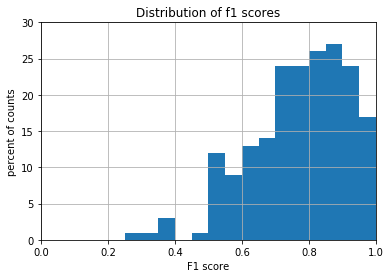

In [131]:
f1_list = [tup[3] for tup in sorted_prfs]
n, bins, patches = plt.hist(f1_list, 15)
plt.xlabel('F1 score')
plt.ylabel('percent of counts')
plt.title('Distribution of f1 scores')
plt.axis([0, 1, 0, 30])
plt.grid(True)
plt.show()

In [170]:
test_y_pred_idxs = np.argmax(test_y_pred, axis=1)

test_y_pred_binary = np.zeros(test_y_pred.shape)
for i, pred_i in enumerate(test_y_pred_idxs):
    test_y_pred_binary[i, pred_i] = 1

### AUROC scores

In [177]:
roc_auc_scores = roc_auc_score(test_y_true, test_y_pred_binary, average=None)
roc_auc_scores_macro = roc_auc_score(test_y_true, test_y_pred_binary, average='macro')
roc_auc_scores_weighted = roc_auc_score(test_y_true, test_y_pred_binary, average='weighted')

print(len(roc_auc_scores), roc_auc_scores_macro, roc_auc_scores_weighted)

196 0.887118616315 0.884899013736


In [179]:
zipped_aucs = list(zip(target_names, roc_auc_scores))
sorted_aucs = sorted(zipped_aucs, key=lambda tup: tup[1])
sorted_aucs[:5]

[('Audi-A5_Coupe-2012', 0.59028848685447777),
 ('Audi-S4_Sedan-2012', 0.59999999999999998),
 ('Rolls_Royce-Phantom_Drophead_Coupe_Convertible-2012', 0.61538461538461542),
 ('Chevrolet-Silverado_1500_Hybrid_Crew_Cab-2012', 0.64265061662831169),
 ('Aston_Martin-Martin_V8_Vantage_Convertible-2012', 0.65909090909090906)]

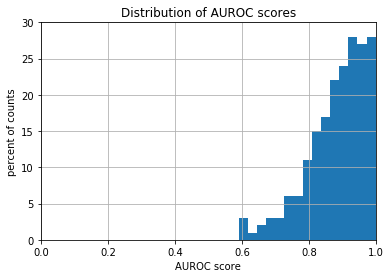

In [191]:
auc_list = [tup[1] for tup in sorted_aucs]
n, bins, patches = plt.hist(auc_list, 15)
plt.xlabel('AUROC score')
plt.ylabel('percent of counts')
plt.title('Distribution of AUROC scores')
plt.axis([0, 1, 0, 30])
plt.grid(True)
plt.show()

In [192]:
for fail in sorted_aucs[0:5]:
    print('\nSummary for: {}, score: {}'.format(fail[0], round(fail[1],2)))
    fail_cnf = cnf_matrix[reverse_lookup_dict[fail[0]],:]
    pred_idx = np.nonzero(fail_cnf)
    pred_labels = list(zip(np.array(target_names)[pred_idx], fail_cnf[pred_idx]))
    sorted_labels = sorted(pred_labels, key=lambda tup: tup[1], reverse=True)
    for tup in sorted_labels:
        print(tup)


Summary for: Audi-A5_Coupe-2012, score: 0.59
('Audi-S5_Coupe-2012', 5)
('Audi-TTS_Coupe-2012', 3)
('Audi-A5_Coupe-2012', 2)
('Audi-S4_Sedan-2007', 1)

Summary for: Audi-S4_Sedan-2012, score: 0.6
('Audi-S5_Coupe-2012', 5)
('Audi-S4_Sedan-2012', 2)
('Audi-A5_Coupe-2012', 1)
('Audi-TTS_Coupe-2012', 1)
('BMW-1_Series_Coupe-2012', 1)

Summary for: Rolls_Royce-Phantom_Drophead_Coupe_Convertible-2012, score: 0.62
('Rolls_Royce-Phantom_Sedan-2012', 6)
('Rolls_Royce-Phantom_Drophead_Coupe_Convertible-2012', 3)
('Ford-Mustang_Convertible-2007', 1)
('Mercedes_Benz-300_Class_Convertible-1993', 1)
('Nissan-240SX_Coupe-1998', 1)
('Rolls_Royce-Ghost_Sedan-2012', 1)

Summary for: Chevrolet-Silverado_1500_Hybrid_Crew_Cab-2012, score: 0.64
('Chevrolet-Avalanche_Crew_Cab-2012', 3)
('Chevrolet-Silverado_1500_Hybrid_Crew_Cab-2012', 2)
('Chevrolet-Silverado_1500_Extended_Cab-2012', 1)
('Dodge-Ram_Pickup_3500_Quad_Cab-2009', 1)

Summary for: Aston_Martin-Martin_V8_Vantage_Convertible-2012, score: 0.66
('Ast

### Comparing AUROC and F1 (they are about the same)

In [181]:
for i, tup in enumerate(sorted_aucs[:10]):
    print('Worst {}, AUC: {}, f1:{}'.format(i, tup[0], sorted_prfs[i][0]))

Worst 0, AUC: Audi-A5_Coupe-2012, f1:Audi-A5_Coupe-2012
Worst 1, AUC: Audi-S4_Sedan-2012, f1:Audi-S4_Sedan-2012
Worst 2, AUC: Rolls_Royce-Phantom_Drophead_Coupe_Convertible-2012, f1:Audi-S5_Coupe-2012
Worst 3, AUC: Chevrolet-Silverado_1500_Hybrid_Crew_Cab-2012, f1:Rolls_Royce-Phantom_Drophead_Coupe_Convertible-2012
Worst 4, AUC: Aston_Martin-Martin_V8_Vantage_Convertible-2012, f1:Chevrolet-Silverado_1500_Hybrid_Crew_Cab-2012
Worst 5, AUC: Audi-TT_Hatchback-2011, f1:Aston_Martin-Martin_V8_Vantage_Convertible-2012
Worst 6, AUC: Chevrolet-Silverado_2500HD_Regular_Cab-2012, f1:Aston_Martin-Martin_Virage_Convertible-2012
Worst 7, AUC: Toyota-Camry_Sedan-2012, f1:Audi-TT_Hatchback-2011
Worst 8, AUC: Land_Rover-Rover_LR2_SUV-2012, f1:Bugatti-Veyron_16.4_Coupe-2009
Worst 9, AUC: Aston_Martin-Martin_Virage_Convertible-2012, f1:Chevrolet-Silverado_2500HD_Regular_Cab-2012


In [187]:
worst_auc = [tup[0] for tup in sorted_aucs[:10]]
worst_f1 = [tup[0] for tup in sorted_prfs[:10]]

worst_auc_not_f1 = [item for item in worst_auc if item not in worst_f1]
worst_f1_not_auc = [item for item in worst_f1 if item not in worst_auc]

print(worst_auc_not_f1)
print(worst_f1_not_auc)

['Toyota-Camry_Sedan-2012', 'Land_Rover-Rover_LR2_SUV-2012']
['Audi-S5_Coupe-2012', 'Bugatti-Veyron_16.4_Coupe-2009']


### Body-type clustering

In [198]:
body_list = [
    'N/A','SEDAN','SUV', 'PICKUP','VAN','MINIVAN',
    'HATCHBACK','CONVERTIBLE','COUPE','WAGON',
]
 
label_category_dict = {}

for label in target_names:
    label_category_dict[label]={}
    label_split = label.split('-')
    make = label_split[0].replace('_', ' ')
    year = label_split[-1]
    if make == 'Mercedes Benz':
        make = 'Mercedes-Benz'
    # print(make)
    body_style = 'N/A'
    model = label_split[1].replace('_', ' ')
    try:
        if model.split(' ')[0] in ['Martin', 'Rover']:
            model = ' '.join(model.split(' ')[1:])
        if model.split(' ')[-1].upper() in body_list:
            body_style = model.split(' ')[-1].upper()
            model = ' '.join(model.split(' ')[:-1])
        if model.split(' ')[1].lower() in ['class', 'series']:
            model = '-'.join(model.split(' ')[:2]) +\
            ' ' + ' '.join(model.split(' ')[2:])
        if model.split(' ')[-1].upper() == 'CAB':
            body_style = 'PICKUP'
    except IndexError:
        pass
    
    content_key_list = [(label, 'label'), (make, 'make'), (model, 'model'),
                        (year, 'year'), (body_style, 'body_style'),]
    for content_key_tup in content_key_list:
        label_category_dict[label][content_key_tup[1]]=content_key_tup[0]

In [203]:
pickle_variable_to_path(label_category_dict, 'label_category_dict', SAVE_DIR)

In [205]:
for key, item in label_category_dict.items():
    if item['body_style'] == 'N/A':
        print(key)

Acura-Integra_Type_R-2001
Acura-TL_Type_S-2008
Buick-Regal_GS-2012
Chevrolet-Cobalt_SS-2010
Chevrolet-Corvette_Ron_Fellows_Edition_Z06-2007
Chevrolet-Corvette_ZR1-2012
Chevrolet-HHR_SS-2010
Chevrolet-TrailBlazer_SS-2009
Chrysler-300_SRT_8-2010
Dodge-Challenger_SRT8-2011
Dodge-Charger_SRT_8-2009
FIAT-500_Abarth-2012
Ford-Ranger_SuperCab-2011
Infiniti-G_Coupe_IPL-2012
Jaguar-XK_XKR-2012
Lamborghini-Gallardo_LP_570_4_Superleggera-2012


In [209]:
corrections = [
    (['Acura-Integra_Type_R-2001', 
      'Chevrolet-Cobalt_SS-2010',
      'Chevrolet-Corvette_Ron_Fellows_Edition_Z06-2007',
      'Chevrolet-Corvette_ZR1-2012',
      'Dodge-Challenger_SRT8-2011',
      'Infiniti-G_Coupe_IPL-2012',
      'Jaguar-XK_XKR-2012',
      'Lamborghini-Gallardo_LP_570_4_Superleggera-2012',], 'COUPE'),
    (['Acura-TL_Type_S-2008',
      'Buick-Regal_GS-2012',
      'Chrysler-300_SRT_8-2010',
      'Dodge-Charger_SRT_8-2009',], 'SEDAN'),
    (['Chevrolet-HHR_SS-2010',
      'Chevrolet-TrailBlazer_SS-2009',], 'SUV'),
    (['FIAT-500_Abarth-2012',], 'HATCHBACK'),
    (['Ford-Ranger_SuperCab-2011',], 'PICKUP'),
]

In [210]:
for key, item in label_category_dict.items():
    for correction_tup in corrections:
        if key in correction_tup[0]:
            item['body_style'] = correction_tup[1]
            print(key, correction_tup[1])           

Acura-Integra_Type_R-2001 COUPE
Acura-TL_Type_S-2008 SEDAN
Buick-Regal_GS-2012 SEDAN
Chevrolet-Cobalt_SS-2010 COUPE
Chevrolet-Corvette_Ron_Fellows_Edition_Z06-2007 COUPE
Chevrolet-Corvette_ZR1-2012 COUPE
Chevrolet-HHR_SS-2010 SUV
Chevrolet-TrailBlazer_SS-2009 SUV
Chrysler-300_SRT_8-2010 SEDAN
Dodge-Challenger_SRT8-2011 COUPE
Dodge-Charger_SRT_8-2009 SEDAN
FIAT-500_Abarth-2012 HATCHBACK
Ford-Ranger_SuperCab-2011 PICKUP
Infiniti-G_Coupe_IPL-2012 COUPE
Jaguar-XK_XKR-2012 COUPE
Lamborghini-Gallardo_LP_570_4_Superleggera-2012 COUPE


In [211]:
pickle_variable_to_path(label_category_dict, 'label_category_dict_corrected', SAVE_DIR)

In [ ]:
"""
make a predictions_list with each entry a dictionary with these keys:
true_label
true_body
p1_label
p1_body
...
p5_label
p5_body
"""

In [221]:
reverse_lookup_dict['GMC-Canyon_Extended_Cab-2012']

119

In [233]:
def find_top_prediction_indices(prediction_array_row):
    """
    prediction array row should be shape (classes,)
    """
    # find the indices of the top 5 predictions for each row
    top_idxs = np.argpartition(prediction_array_row, -4)[-5:]
    # sort them from greatest to lowest
    top_idxs = top_idxs[np.argsort(prediction_array_row[top_idxs])][::-1]
    return top_idxs

# show that it worked
print(test_y_pred[0, find_top_prediction_indices(test_y_pred[0,:])])

[  9.99e-01   7.47e-04   2.20e-05   2.91e-06   2.21e-09]


In [235]:
prediction_dict_list = []
for row in range(test_y_true.shape[0]):
    prediction_dict = {}
    true_idx = np.argmax(test_y_true[row,:])
    true_label = lookup_dict[true_idx]
    prediction_dict['true_label'] = true_label
    prediction_dict['true_body'] = label_category_dict[true_label]['body_style']
    top_idxs = find_top_prediction_indices(test_y_pred[row,:])
    for order, i in enumerate(top_idxs):
        pred_label = lookup_dict[i]
        pred_body = label_category_dict[pred_label]['body_style']
        prediction_dict['p{}_label'.format(order+1)] = pred_label
        prediction_dict['p{}_body'.format(order+1)] = pred_body
    prediction_dict_list.append(prediction_dict)

prediction_dict_list[0]

{'p1_body': 'PICKUP',
 'p1_label': 'GMC-Canyon_Extended_Cab-2012',
 'p2_body': 'PICKUP',
 'p2_label': 'Ford-F_150_Regular_Cab-2012',
 'p3_body': 'SUV',
 'p3_label': 'Isuzu-Ascender_SUV-2008',
 'p4_body': 'SUV',
 'p4_label': 'Dodge-Durango_SUV-2007',
 'p5_body': 'SUV',
 'p5_label': 'Jeep-Liberty_SUV-2012',
 'true_body': 'PICKUP',
 'true_label': 'GMC-Canyon_Extended_Cab-2012'}

In [237]:
import pandas as pd

body_df = pd.DataFrame.from_records(prediction_dict_list)

In [238]:
body_df.head()

,p1_body,p1_label,p2_body,p2_label,p3_body,p3_label,p4_body,p4_label,p5_body,p5_label,true_body,true_label
0,PICKUP,GMC-Canyon_Extended_Cab-2012,PICKUP,Ford-F_150_Regular_Cab-2012,SUV,Isuzu-Ascender_SUV-2008,SUV,Dodge-Durango_SUV-2007,SUV,Jeep-Liberty_SUV-2012,PICKUP,GMC-Canyon_Extended_Cab-2012
1,CONVERTIBLE,FIAT-500_Convertible-2012,COUPE,Acura-Integra_Type_R-2001,COUPE,Chevrolet-Cobalt_SS-2010,COUPE,BMW-M3_Coupe-2012,HATCHBACK,Hyundai-Elantra_Touring_Hatchback-2012,COUPE,Acura-Integra_Type_R-2001
2,PICKUP,Dodge-Dakota_Club_Cab-2007,PICKUP,Dodge-Dakota_Crew_Cab-2010,PICKUP,Chevrolet-Silverado_1500_Extended_Cab-2012,PICKUP,Chevrolet-Silverado_1500_Regular_Cab-2012,PICKUP,Chevrolet-Avalanche_Crew_Cab-2012,PICKUP,Dodge-Dakota_Club_Cab-2007
3,SEDAN,Audi-100_Sedan-1994,SEDAN,Audi-V8_Sedan-1994,SEDAN,Mercedes_Benz-C_Class_Sedan-2012,PICKUP,Ford-Ranger_SuperCab-2011,COUPE,Audi-S5_Coupe-2012,SEDAN,Audi-V8_Sedan-1994
4,COUPE,Aston_Martin-Martin_Virage_Coupe-2012,COUPE,Bentley-Continental_GT_Coupe-2007,SEDAN,Buick-Verano_Sedan-2012,COUPE,Ferrari-FF_Coupe-2012,COUPE,Honda-Accord_Coupe-2012,COUPE,Aston_Martin-Martin_V8_Vantage_Coupe-2012


### Not very useful confusion matrix

In [78]:
# This function is copied from here: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          size=(200, 200),
                          cmap=plt.cm.bwr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig = plt.gcf()
    fig.set_size_inches(size[0], size[1])

Confusion matrix, without normalization


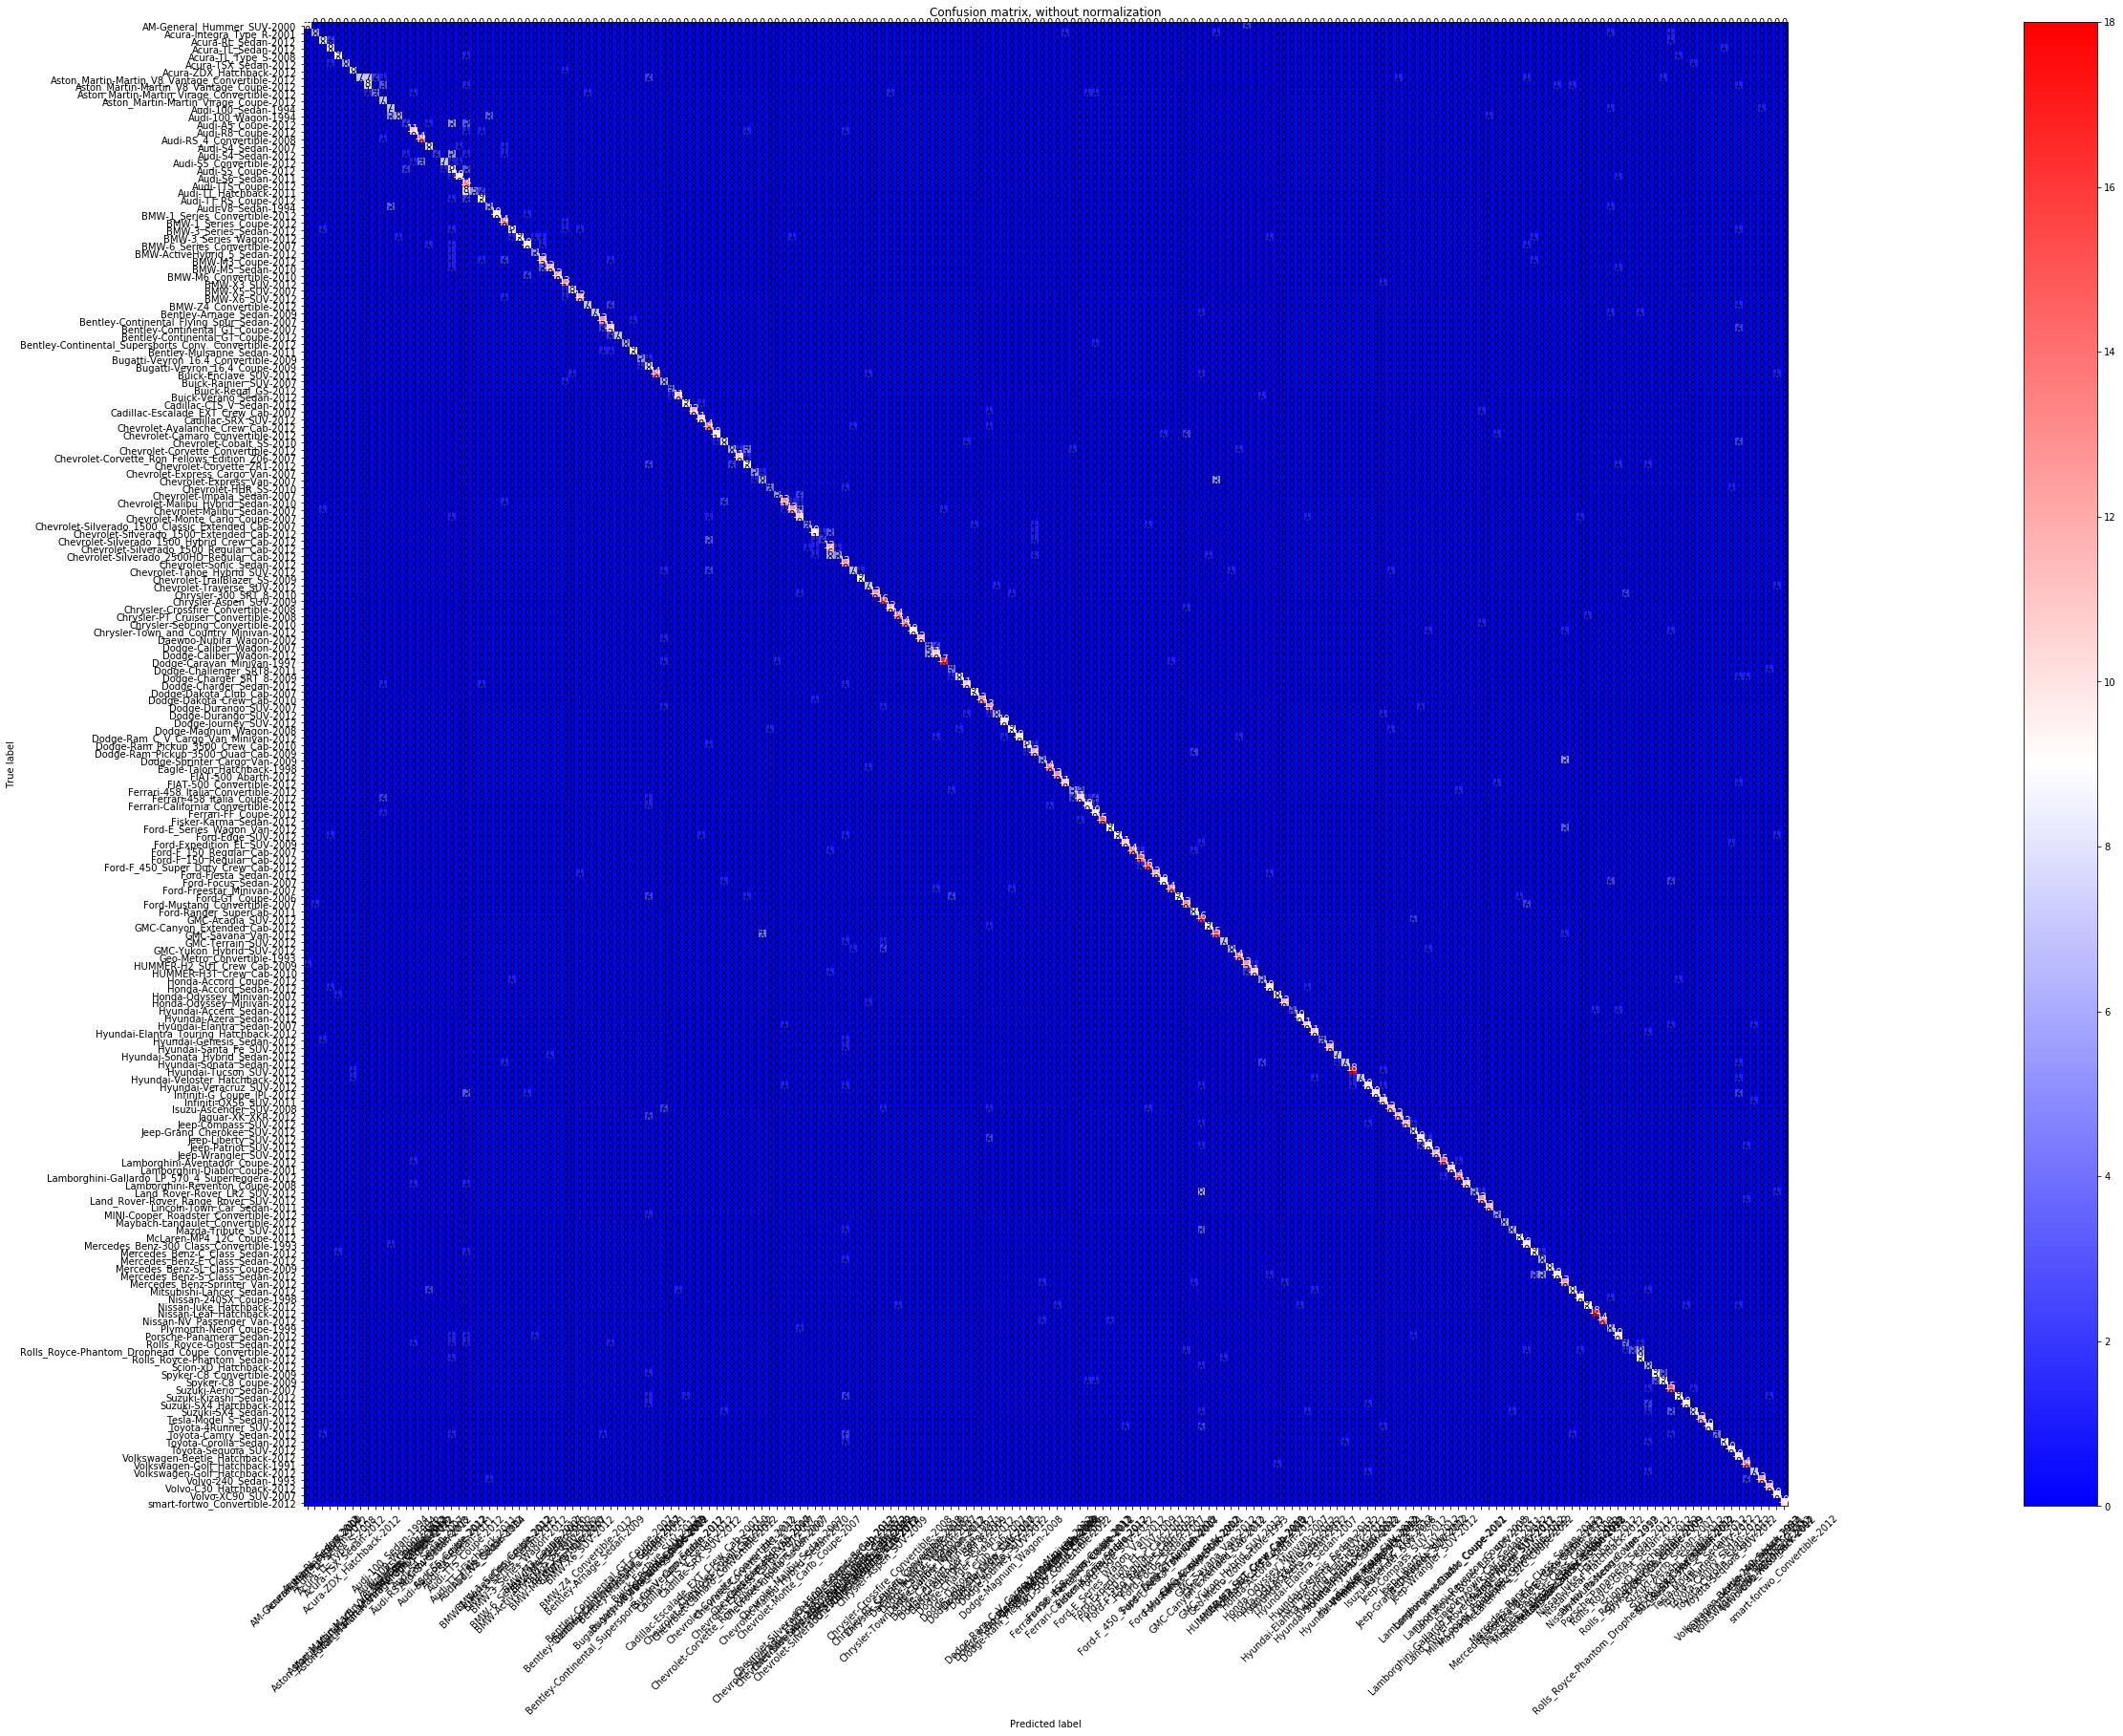

In [72]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.show()